# Dataset Selection and Information

I chose to work with the **Intel Image Classification Dataset** available on Kaggle.

- **Dataset link**: [https://www.kaggle.com/datasets/puneet6060/intel-image-classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
- **Instances**: 25,000+ images
- **Classes**: 6 (Buildings, Forest, Glacier, Mountain, Sea, Street)
- **Image Size**: 150x150 pixels 
- **Target**: Multiclass classification  
  - `buildings`
  - `forest`
  - `glacier`
  - `mountain`
  - `sea`
  - `street`


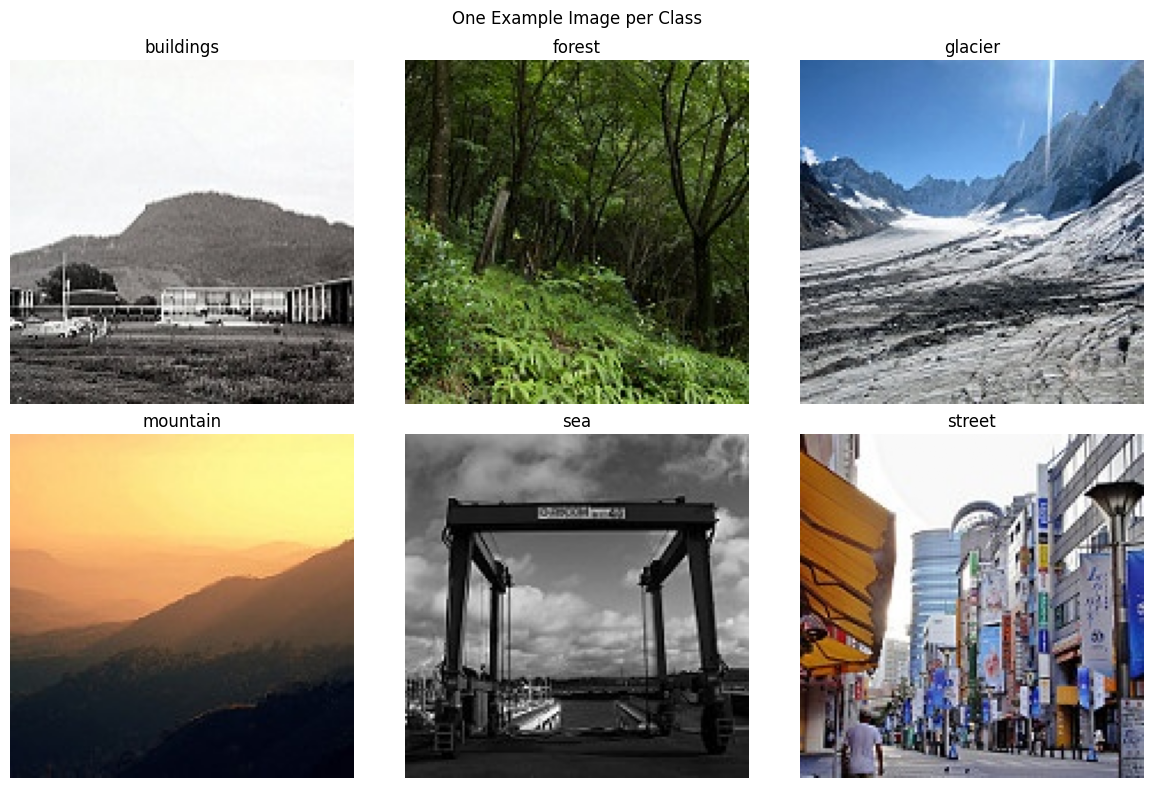

Training set class distribution:
  buildings: 2191 images
  forest: 2271 images
  glacier: 2404 images
  mountain: 2512 images
  sea: 2274 images
  street: 2382 images


In [ ]:
# Data Visualization and Distribution

# Imports
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from collections import Counter

# Define paths
data_dir = "data"
train_path = os.path.join(data_dir, "seg_train")

# Transformation to resize and convert image to tensor - For this task, resizing to 150x150 will speed up training but should still provide good information (see reference [4])
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

# Display one image per class
plt.figure(figsize=(12, 8))
for idx, class_name in enumerate(sorted(os.listdir(train_path))):
    class_dir = os.path.join(train_path, class_name)
    if not os.path.isdir(class_dir):
        continue
    # Load first image in the class folder
    img_file = os.listdir(class_dir)[0]
    img_path = os.path.join(class_dir, img_file)
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img)
    img_np = img_tensor.permute(1, 2, 0).numpy()
    
    # Plot
    plt.subplot(2, 3, idx + 1)
    plt.imshow(img_np)
    plt.title(class_name)
    plt.axis('off')

plt.suptitle("One Example Image per Class")
plt.tight_layout()
plt.show()

# Print training set class distribution
train_counts = Counter()
for class_name in os.listdir(train_path):
    class_dir = os.path.join(train_path, class_name)
    if os.path.isdir(class_dir):
        train_counts[class_name] = len(os.listdir(class_dir))

print("Training set class distribution:")
for class_name, count in sorted(train_counts.items()):
    print(f"  {class_name}: {count} images")


The distribuitons of the training set data is balanced, there is already testing data seperated from the source, this is a good place to start our model.

## Model Architecture

I designed a CNN with three Conv->ReLU->MaxPool blocks to gradualy build up feature complexity while reducing overfitting

- **Block 1**: 32 filters, feature maps go from 150x150 -> 75x75  
  - Captures low level textures
- **Block 2**: 64 filters, feature maps go from 75x75 -> 37x37  
  - Learns more complex patterns
- **Block 3**: 128 filters, feature maps go from 37x37 -> 18x18  
  - Extracts high level patterns

This choice of doubling filters at each block and halving spatial resolution was adopted from an assignment at RPI given as a part of the Introduction to Ai course.

After the blocks we:
- Flatten the 18x18x128 tensor into a vector
- Fully connected layter of 256 units with ReLU to combine the learned features. This was just chosen arbitrarely. When I work with CNNS of this size I usualy do somthing between 128->512
- 50% dropout to help with overfitting
- A final 6 unit output layer where we have one for each class

In [ ]:
# Model Definition

# Imports
import torch
import torch.nn as nn

class CNNClassifier(nn.Module): # See reference [1]
    def __init__(self, num_classes=6):
        super(CNNClassifier, self).__init__()
        # 3(RGB)a->32 channels, feature map 150x150->75x75
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 32->64 channels, feature map 75x75->37x37
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # 64->128 channels, feature mapo 37x37->18x18
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Fully connected classifier
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 18 * 18, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return self.fc(x)


In [ ]:
# Training loop

import torch.optim as optim
from sklearn.metrics import accuracy_score

# Initialize model and move to device
model = CNNClassifier(num_classes=len(class_names)).to(device)

# Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    # Train on all batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

    # Calculate Eval Metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_targets, all_preds)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")


Epoch 1/10 | Train Loss: 1.0748 | Train Acc: 0.5804
Epoch 2/10 | Train Loss: 0.7350 | Train Acc: 0.7271
Epoch 3/10 | Train Loss: 0.5851 | Train Acc: 0.7908
Epoch 4/10 | Train Loss: 0.4907 | Train Acc: 0.8216
Epoch 5/10 | Train Loss: 0.4128 | Train Acc: 0.8509
Epoch 6/10 | Train Loss: 0.3435 | Train Acc: 0.8765
Epoch 7/10 | Train Loss: 0.2755 | Train Acc: 0.9012
Epoch 8/10 | Train Loss: 0.2369 | Train Acc: 0.9160
Epoch 9/10 | Train Loss: 0.1848 | Train Acc: 0.9349
Epoch 10/10 | Train Loss: 0.1549 | Train Acc: 0.9453


In [19]:
# Test evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_targets, all_preds)
test_precision = precision_score(all_targets,all_preds,average = 'macro') # see reference ([2])
test_recall = recall_score(all_targets,all_preds, average = 'macro')
test_f1 = f1_score(all_targets, all_preds, average = 'macro')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.8360
Test Precision: 0.8366
Test Recall: 0.8384
Test F1 Score: 0.8372


## Evaluation

The generalization gap between training and test accuracy is about 11% which indicates some overfitting in the model. This suggest it could benifit from some regularization or data augmentation.
The precision, recall, and acuracy are all approximatly 83% which indicates a balenced performance without a strong bias to false positives or false negatives.

## Same classification goal but with ResNet-50

In [ ]:
# ResNet-50 Transfer Learning Model (see reference[3])

# Imports
import torch
import torch.nn as nn 
from torchvision.models import resnet50, ResNet50_Weights

# Load pretrained ResNet-50 
model_resnet = resnet50(weights=ResNet50_Weights.DEFAULT)

# Replace the classification layer with our 6
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, len(class_name))

# Move model to device
model_resnet = model_resnet.to(device)

In [ ]:
# ResNet-50 Training Loop

# Imports
import torch.optim as optim
from sklearn.metrics import accuracy_score

# Only parameters of final layer are being optimized
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_epochs = 10
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model_resnet.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    # Train on all batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

    # Calculate Eval Metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_targets, all_preds)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")


Epoch 1/10 | Train Loss: 0.2711 | Train Acc: 0.9052
Epoch 2/10 | Train Loss: 0.2415 | Train Acc: 0.9149
Epoch 3/10 | Train Loss: 0.2293 | Train Acc: 0.9168
Epoch 4/10 | Train Loss: 0.2167 | Train Acc: 0.9218
Epoch 5/10 | Train Loss: 0.2128 | Train Acc: 0.9241
Epoch 6/10 | Train Loss: 0.2033 | Train Acc: 0.9274
Epoch 7/10 | Train Loss: 0.2053 | Train Acc: 0.9237
Epoch 8/10 | Train Loss: 0.1879 | Train Acc: 0.9319
Epoch 9/10 | Train Loss: 0.1881 | Train Acc: 0.9305
Epoch 10/10 | Train Loss: 0.1811 | Train Acc: 0.9344


In [24]:
# Test evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model_resnet.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_resnet(images)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_targets, all_preds)
test_precision = precision_score(all_targets,all_preds,average = 'macro') # see reference ([2])
test_recall = recall_score(all_targets,all_preds, average = 'macro')
test_f1 = f1_score(all_targets, all_preds, average = 'macro')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.9013
Test Precision: 0.9034
Test Recall: 0.9046
Test F1 Score: 0.9039


## Evaluation

The generalization gap between training and test accuracy is about 3% which is much lower than my self implemented model. This indicates that ResNet-50 is less prone to overfitting when trianed over 10 epochs. The overall triaing accuracy is slightly less for ResNet though despite it starting with a much higher training accuracy. The ResNet-50 model prefromed about 7% better across all preformance metrics indicating the transfer learning learned more than my CNN.

## Increasing Data Variaty

In [ ]:
# Data Augmentation for Training Set

# Imports 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# resize -> random flip -> random rotation -> to tensor (See refernce [4])
train_transform_aug = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(p=0.5),   # half the images flipped
    transforms.RandomRotation(degrees=30),     # rotate up to 30 degrees
    transforms.ToTensor()
])

# Validation/test transforms remain 
val_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

# Reload datasets 
train_dataset = datasets.ImageFolder(train_path, transform=train_transform_aug)
test_dataset  = datasets.ImageFolder(test_path,  transform=val_transform)

# Recreate DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size)

In [26]:
# Training loop

import torch.optim as optim
from sklearn.metrics import accuracy_score

# Initialize model and move to device
model = CNNClassifier(num_classes=len(class_names)).to(device)

# Hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    # Train on all batches
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

    # Calculate Eval Metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = accuracy_score(all_targets, all_preds)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f}")


Epoch 1/10 | Train Loss: 1.1421 | Train Acc: 0.5568
Epoch 2/10 | Train Loss: 0.9018 | Train Acc: 0.6589
Epoch 3/10 | Train Loss: 0.7781 | Train Acc: 0.7184
Epoch 4/10 | Train Loss: 0.7091 | Train Acc: 0.7416
Epoch 5/10 | Train Loss: 0.6336 | Train Acc: 0.7729
Epoch 6/10 | Train Loss: 0.5977 | Train Acc: 0.7872
Epoch 7/10 | Train Loss: 0.5645 | Train Acc: 0.7961
Epoch 8/10 | Train Loss: 0.5329 | Train Acc: 0.8122
Epoch 9/10 | Train Loss: 0.5150 | Train Acc: 0.8184
Epoch 10/10 | Train Loss: 0.5076 | Train Acc: 0.8236


In [27]:
# Test evaluation

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

test_acc = accuracy_score(all_targets, all_preds)
test_precision = precision_score(all_targets,all_preds,average = 'macro') # see reference ([2])
test_recall = recall_score(all_targets,all_preds, average = 'macro')
test_f1 = f1_score(all_targets, all_preds, average = 'macro')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.8373
Test Precision: 0.8407
Test Recall: 0.8399
Test F1 Score: 0.8391


## Evaluate

With augmentation the training accuracy dropped 94% -> 82% because random flips and rotations make the model see harder examples. Test accuracy went up by 0.10% (so basicaly the same), and precision/recall/F1 all went up by about 0.3%(Also about the same). These changes show that augmentation acts as a regularizer which reducing overfitting on the training set and still gives about the same result on unseen data.

   ## References

1. GeeksforGeeks. (n.d.). *Introduction to Convolutional Neural Network*.  
   Retrieved from https://www.geeksforgeeks.org/machine-learning/introduction-convolution-neural-network

2. Masoud, I. (2022, June 19). *Understanding Micro, Macro, and Weighted Averages for scikit-learn Metrics in Multi-class Classification with Example*.  
   Retrieved from https://iamirmasoud.com/2022/06/19/understanding-micro-macro-and-weighted-averages-for-scikit-learn-metrics-in-multi-class-classification-with-example

3. PyTorch. (n.d.). Vision models.  
   Retrieved from https://docs.pytorch.org/vision/0.22/models.html

4. PyTorch. (n.d.). *transforms — Torchvision*.  
   Retrieved from https://docs.pytorch.org/vision/0.9/transforms.html
